# LOAD package

In [4]:
pwd

'/home/yunzheng/PAC/code/color_distribution'

In [1]:
from astropy.io import fits
import numpy as np
from multiprocessing import Process
from sklearn.neighbors import BallTree
from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from astropy.table import Table,Column,vstack,hstack
from astropy.io import ascii
import os
import matplotlib.colors as mcolors

In [2]:
from astropy.cosmology import FlatLambdaCDM,z_at_value
cosmo = FlatLambdaCDM(H0 = 67.74,Om0 = 0.3089,Ob0 = 0.0486)
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

In [3]:
import seaborn as sns
sns.set()

# LOAD data

In [5]:
# in = Table.read("/home/yunzheng/PAC/code/sdss/SEDfitting/sdss.fits")
out = Table.read("/home/yunzheng/PAC/code/sdss/spec/SEDfitting/out/results.fits")
# out_old = Table.read("./SEDfitting/out_old/results.fits")
bright = Table.read("/home/yunzheng/PAC/code/sdss/spec/spec_catalogue/spec.fits")
vmax = Table.read("/home/yunzheng/PAC/code/sdss/spec/spec_catalogue/spec_vmax.fits")

In [55]:
u = out['bayes.param.restframe_Lnu(sdss.up)']
r = out['bayes.param.restframe_Lnu(sdss.rp)']
u_r = -2.5 * np.log10(u/r)
mass = out['bayes.stellar.m_star']
mass = np.log10(mass)
redshift = bright['Z_1']
g = out['bayes.param.restframe_Lnu(sdss.gp)']
g_r = -2.5 * np.log10(g/r)


zmax = vmax['ZMAX_LOCAL']
zmin = vmax['ZMIN_LOCAL']

## 0-0.3

In [7]:
index = ((redshift<=0.3)&(redshift>0))
u_r = u_r[index]
# g_r = g_r[index]
mass = mass[index]
redshift = redshift[index]
# u_r_0 = u_r_0[index]
zmax = zmax[index]
zmin = zmin[index]

In [8]:
mass.shape

(483207,)

In [10]:
zmax[zmax>0.3]=0.3

In [15]:
np.max(u_r)

3.983275458106762

In [16]:
np.min(u_r)

0.007852294698938478

In [11]:
Vtotal = cosmo.comoving_volume(0.3) - cosmo.comoving_volume(0.0)
print(Vtotal.value)

V_0 = []
for i in range(len(zmax)):
    temp = cosmo.comoving_volume(zmax[i]) - cosmo.comoving_volume(0.0)
    V_0.append(temp.value)
    
V_1 = np.array(V_0)
weight1 = Vtotal.value/V_1

7830226036.307256


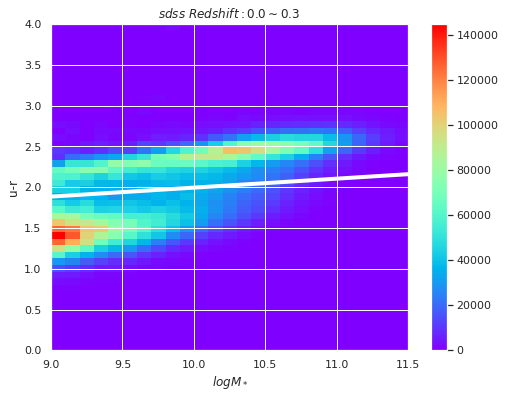

In [38]:
plt.figure(figsize = (8,6))
counts, xbins, ybins = np.histogram2d(mass, u_r,  bins=[30,50],range=[[9,12],[0,4]],weights = weight1)
# print(xbins)
counts = counts.T
counts = counts[::-1]
# weight2 = counts / np.sum(counts,axis = 0)
# weight2[weight2==0]=np.nan
plt.imshow(counts,cmap='rainbow',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],aspect='auto')
plt.colorbar()
# plt.plot([9.0,0.52796795083083],[10,0.5819679508308301],color = "red",linewidth = 2,label="cut")
# plt.plot([9.0,12.0],[0.52796795083083,0.6899679508308301],"white",linewidth = 2,label="cut")
plt.plot([9.0,12.0],[1.885,2.215],"-",color = "white",linewidth = 4,label="cut")

plt.xlabel("$log M_*$")
plt.ylabel("u-r")
plt.xlim(9,11.5)
# plt.ylim(0,3)
plt.title("$sdss \ Redshift : 0.0 \sim 0.3$")
plt.savefig("./sdss_number_0_3.pdf",dpi = 100)

In [36]:
0.11*9 - 0.45 * 0.1 +0.94

1.8849999999999998

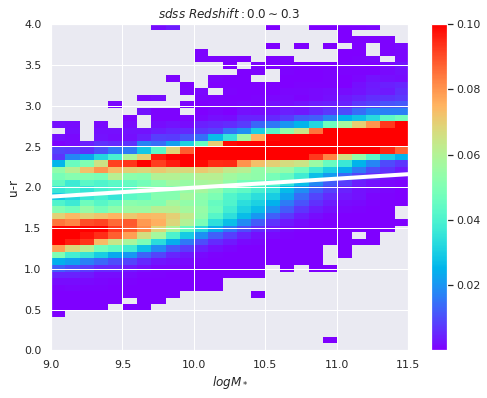

In [37]:
plt.figure(figsize = (8,6))
counts, xbins, ybins = np.histogram2d(mass, u_r,  bins=[30,50],range=[[9,12],[0,4]],weights = weight1)
# print(xbins)
counts = counts.T
counts = counts[::-1]
weight2 = counts / np.sum(counts,axis = 0)
weight2[weight2==0]=np.nan
plt.imshow(weight2,cmap='rainbow',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],aspect='auto',vmax = 0.1)
plt.colorbar()
# plt.plot([9.0,0.52796795083083],[10,0.5819679508308301],color = "red",linewidth = 2,label="cut")
# plt.plot([9.0,12.0],[0.52796795083083,0.6899679508308301],"white",linewidth = 2,label="cut")
plt.plot([9.0,12.0],[1.885,2.215],"-",color = "white",linewidth = 4,label="cut")

plt.xlabel("$log M_*$")
plt.ylabel("u-r")
plt.xlim(9,11.5)
# plt.ylim(0,3)
plt.title("$sdss \ Redshift : 0.0 \sim 0.3$")
plt.savefig("./sdss_density_0_3.pdf",dpi = 100)

In [54]:
np.save("./sdss_0_3.npy",np.array([mass,u_r,weight1]))

In [43]:
massbin = np.array([9.0,9.5,10.0,10.5,11])
All = np.zeros(4)
up = np.zeros(4)
down = np.zeros(4)
frac = np.zeros(4)
for i in range(len(massbin)-1):
    index = ((mass>=massbin[i])&(mass<massbin[i+1])&(u_r>=0.0)&(u_r<=4.0))
    All[i] = np.sum(weight1[index])
    print("The length of All:",len(weight1[index]))
    print(All[i])
    cut = ((u_r[index]-(0.11 * mass[index] - 0.45 * 0.1 + 0.94))>0)
    up[i] = np.sum(weight1[index][cut])
    print("The length of up:",len(weight1[index][cut]))
    print(up[i])
    down[i] = np.sum(weight1[index][~cut])
    print("The length of down:",len(weight1[index][~cut]))
    print(down[i])

The length of All: 24269
5169225.251747261
The length of up: 3173
1514288.644003822
The length of down: 21096
3654936.607743439
The length of All: 54388
3623009.2940497375
The length of up: 14058
1683341.630575599
The length of down: 40330
1939667.6634741388
The length of All: 119216
2919747.8239447484
The length of up: 63912
2084665.8009818757
The length of down: 55304
835082.0229628729
The length of All: 178410
1627753.640753088
The length of up: 146077
1460222.9612976774
The length of down: 32333
167530.6794554104


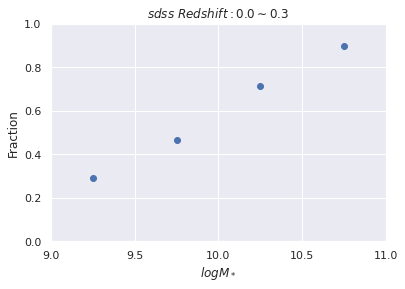

In [53]:
frac = up / All
massbin_0 = 0.5 * (massbin[1:]+massbin[:-1])
plt.scatter(massbin_0,frac)
plt.xlabel("$log M_*$")
plt.ylabel("Fraction")
plt.title("$sdss \ Redshift : 0.0 \sim 0.3$")
plt.xticks(np.arange(9, 11.1, step=0.5))
plt.yticks(np.arange(0, 1.01, step=0.2))
plt.savefig("./sdss_frac_0_3.pdf",dpi=100)

## 0-0.2

In [56]:
index = ((redshift<=0.2)&(redshift>0.0))
u_r = u_r[index]
g_r = g_r[index]
mass = mass[index]
redshift = redshift[index]
# u_r_0 = u_r_0[index]
zmax = zmax[index]
zmin = zmin[index]

In [57]:
u_r.shape

(465225,)

In [58]:
zmax[zmax>0.2] = 0.2

In [59]:
Vtotal = cosmo.comoving_volume(0.2) - cosmo.comoving_volume(0.0)
print(Vtotal.value)

V_0 = []
for i in range(len(zmax)):
    temp = cosmo.comoving_volume(zmax[i]) - cosmo.comoving_volume(0.0)
    V_0.append(temp.value)
    
V_1 = np.array(V_0)
weight1 = Vtotal.value/V_1

2508203453.492786


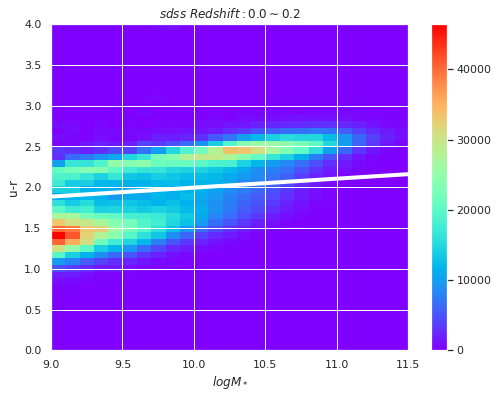

In [61]:
plt.figure(figsize = (8,6))
counts, xbins, ybins = np.histogram2d(mass, u_r,  bins=[30,50],range=[[9,12],[0,4]],weights = weight1)
# print(xbins)
counts = counts.T
counts = counts[::-1]
# weight2 = counts / np.sum(counts,axis = 0)
# weight2[weight2==0]=np.nan
plt.imshow(counts,cmap='rainbow',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],aspect='auto')
plt.colorbar()
# plt.plot([9.0,0.52796795083083],[10,0.5819679508308301],color = "red",linewidth = 2,label="cut")
# plt.plot([9.0,12.0],[0.52796795083083,0.6899679508308301],"white",linewidth = 2,label="cut")
plt.plot([9.0,12.0],[1.885,2.215],"-",color = "white",linewidth = 4,label="cut")

plt.xlabel("$log M_*$")
plt.ylabel("u-r")
plt.xlim(9,11.5)
# plt.ylim(0,3)
plt.title("$sdss \ Redshift : 0.0 \sim 0.2$")
plt.savefig("./sdss_number_0_2.pdf",dpi = 100)

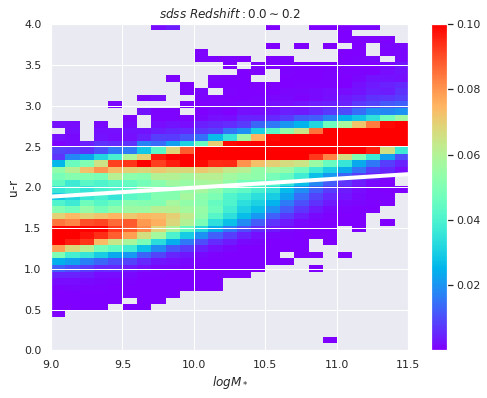

In [64]:
plt.figure(figsize = (8,6))
counts, xbins, ybins = np.histogram2d(mass, u_r,  bins=[30,50],range=[[9,12],[0,4]],weights = weight1)
# print(xbins)
counts = counts.T
counts = counts[::-1]
weight2 = counts / np.sum(counts,axis = 0)
weight2[weight2==0]=np.nan
plt.imshow(weight2,cmap='rainbow',extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],aspect='auto',vmax = 0.1)
plt.colorbar()
# plt.plot([9.0,0.52796795083083],[10,0.5819679508308301],color = "red",linewidth = 2,label="cut")
# plt.plot([9.0,12.0],[0.52796795083083,0.6899679508308301],"white",linewidth = 2,label="cut")
plt.plot([9.0,12.0],[1.885,2.215],"-",color = "white",linewidth = 4,label="cut")

plt.xlabel("$log M_*$")
plt.ylabel("u-r")
plt.xlim(9,11.5)
# plt.ylim(0,3)
plt.title("$sdss \ Redshift : 0.0 \sim 0.2$")
plt.savefig("./sdss_density_0_2.pdf",dpi = 100)

In [65]:
np.save("./sdss_0_2.npy",np.array([mass,u_r,weight1]))

In [66]:
massbin = np.array([9.0,9.5,10.0,10.5,11])
All = np.zeros(4)
up = np.zeros(4)
down = np.zeros(4)
frac = np.zeros(4)
for i in range(len(massbin)-1):
    index = ((mass>=massbin[i])&(mass<massbin[i+1])&(u_r>=0.0)&(u_r<=4.0))
    All[i] = np.sum(weight1[index])
    print("The length of All:",len(weight1[index]))
    print(All[i])
    cut = ((u_r[index]-(0.11 * mass[index] - 0.45 * 0.1 + 0.94))>0)
    up[i] = np.sum(weight1[index][cut])
    print("The length of up:",len(weight1[index][cut]))
    print(up[i])
    down[i] = np.sum(weight1[index][~cut])
    print("The length of down:",len(weight1[index][~cut]))
    print(down[i])

The length of All: 24269
1655823.0334853944
The length of up: 3173
485061.8601383956
The length of down: 21096
1170761.1733469986
The length of All: 54387
1160533.9814064577
The length of up: 14058
539213.4622475179
The length of down: 40329
621320.5191589396
The length of All: 119194
935256.0022758582
The length of up: 63912
667766.9248826612
The length of down: 55282
267489.07739319705
The length of All: 176880
521007.2450935462
The length of up: 145922
467709.02793244127
The length of down: 30958
53298.217161105036


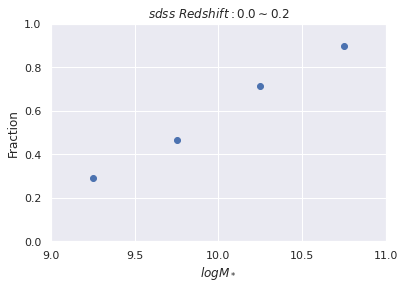

In [69]:
frac = up / All
massbin_0 = 0.5 * (massbin[1:]+massbin[:-1])
plt.scatter(massbin_0,frac)
plt.xlabel("$log M_*$")
plt.ylabel("Fraction")
plt.title("$sdss \ Redshift : 0.0 \sim 0.2$")
plt.xticks(np.arange(9, 11.1, step=0.5))
plt.yticks(np.arange(0, 1.01, step=0.2))
plt.savefig("./sdss_frac_0_2.pdf",dpi=100)

In [68]:
frac

array([0.29294306, 0.46462531, 0.71399373, 0.89770158])